# Image Format vs Fossil Repository Size

## Prerequisites

This notebook was originally developed with standalone [JupyterLab] and Python 2 but was later moved to JupyterLab under [Anaconda] with Python 3. Backporting to Python 2 may require manual adjustment. Getting it running under stock JupyterLab or plain-old-Jupyter should be straightforward for one familiar with the tools. We will assume you're following in my footsteps, using Anaconda.

One of the reasons we switched to Anaconda is that it comes with all but one of this notebook's prerequisites, that last remaining one of which you install so:

    $ pip install wand

That should be done in a shell where "`pip`" is the version that came with Anaconda. Otherwise, the package will likely end up in some *other* Python package tree, which Anaconda's Python kernel may not be smart enough to find on its own.

Note that you do *not* use `conda` for this: as of this writing, [Wand] is not available in a form that installs via `conda`.

This notebook was written and tested on a macOS system where `/tmp` exists. Other platforms may require adjustments to the scripts below.

[Anaconda]:   https://www.anaconda.com/distribution/
[JupyterLab]: https://github.com/jupyterlab/
[Wand]:       http://wand-py.org/


## Running

The next cell generates the test repositories. This takes about 3 seconds to run on my machine. If you have to uncomment the "`sleep`" call in the inner loop, this will go up to about 45 seconds.

The next cell produces the bar chart from the collected data, all but instantaneously.

This split allows you to generate the expensive experimental data in a single pass, then play as many games as you like with the generated data.


## Discussion

That is kept in [a separate document](image-format-vs-repo-size.md) so we can share that document with Fossil's Markdown renderer.

In [1]:
import os
import random
import subprocess
import time

from wand.color import Color
from wand.drawing import Drawing
from wand.image import Image

import pandas as pd

size = 256
iterations = 10
start = time.time()
repo_sizes = []
fossil = '/usr/local/bin/fossil'

if not os.path.isfile(fossil): raise RuntimeError("No such executable " + fossil)
if not os.access(fossil, os.X_OK): raise RuntimeError("Cannot execute " + fossil)

tdir = os.path.join('/tmp', 'image-format-vs-repo-size')
if not os.path.isdir(tdir): os.mkdir(tdir, 0o700)
print("Created test directory " + tdir)
    
formats = ['JPEG', 'BMP', 'TIFF', 'PNG']
for f in formats:
    ext = f.lower()
    wdir = os.path.join(tdir, 'work-' + ext)
    if not os.path.isdir(wdir): os.mkdir(wdir, 0o700)
    os.chdir(wdir)
    repo = '../test-' + ext + '.fossil'
    ifn = 'test.' + ext
    ipath = os.path.join(wdir, ifn)
    rs = []
    
    def add_repo_size():
        rs.append(os.path.getsize(repo) / 1024.0 / 1024.0)
        
    def set_repo_page_size(n):
        subprocess.run([
            fossil,
            'rebuild',
            '--compress',
            '--pagesize',
            str(n),
            '--vacuum'
        ])

    try:
        # Create test repo
        subprocess.run([fossil, 'init', repo])
        subprocess.run([fossil, 'open', repo])
        subprocess.run([fossil, 'set', 'binary-glob', "*.{0}".format(ext)])
        set_repo_page_size(512)    # minimum
        add_repo_size()
        set_repo_page_size(8192)   # default
        print("Created " + repo + " for format " + f + ".")

        # Create test image and add it to the repo
        img = Image(width = size, height = size, depth = 8,
                    background = 'white')
        img.alpha_channel = 'remove'
        img.evaluate('gaussiannoise', 1.0)
        img.save(filename = ipath)
        subprocess.run([fossil, 'add', ifn])
        subprocess.run([fossil, 'ci', '-m', 'initial'])
        #print("Added initial " + f + " image.")
        add_repo_size()

        # Change a random pixel to a random RGB value and check it in
        # $iterations times.
        for i in range(iterations - 1):
            with Drawing() as draw:
                x = random.randint(0, size - 1)
                y = random.randint(0, size - 1)

                r = random.randint(0, 255)
                g = random.randint(0, 255)
                b = random.randint(0, 255)
                
                draw.fill_color = Color('rgb({0},{1},{2})'.format(
                    r, g, b
                ))
                draw.color(x, y, 'point')
                draw(img)
                img.save(filename = ipath)
                
                # You might need to uncomment the next line if you find that
                # the repo size doesn't change as expected.  In some versions
                # of Wand (or is it the ImageMagick underneath?) we have seen
                # what appear to be asynchronous saves, with a zero-length file
                # here if you don't wait for the save to complete.
                #time.sleep(1.0)
  
                subprocess.run([fossil, 'ci', '-m', '"change {0} step {1}'.format(
                    f, i
                )])
                add_repo_size()
                
        # Repo complete for this format
        repo_sizes.append(pd.Series(rs, name=f))

    finally:
        if os.path.exists(ipath): os.remove(ipath)
        if os.path.exists(tdir):
            if os.path.isfile(repo):
                subprocess.run([fossil, 'close', '-f'])
                os.unlink(repo)
            os.chdir(tdir);
            os.rmdir(wdir)
        if os.path.exists(repo): os.remove(repo)
            
print("Experiment completed in " + str(time.time() - start) + " seconds.")

Created test directory /tmp/image-format-vs-repo-size
Created ../test-jpeg.fossil for format JPEG.
Created ../test-bmp.fossil for format BMP.
Created ../test-tiff.fossil for format TIFF.
Created ../test-png.fossil for format PNG.
Experiment completed in 3.0627901554107666 seconds.


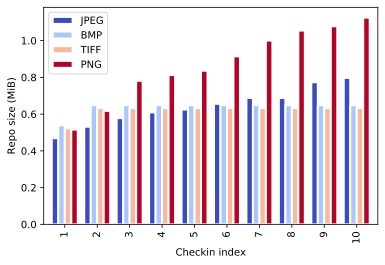

In [1]:
%config InlineBackend.figure_formats = ['svg']

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

os.chdir(tdir)

# Merge per-format test data into a single DataFrame without the first
# first row, being the boring initial empty repo state.
data = pd.concat(repo_sizes, axis=1).drop(range(1))

mpl.rcParams['figure.figsize'] = (6, 4)
ax = data.plot(kind = 'bar', colormap = 'coolwarm',
          grid = False, width = 0.8,
          edgecolor = 'white', linewidth = 2)
ax.axes.set_xlabel('Checkin index')
ax.axes.set_ylabel('Repo size (MiB)')
plt.savefig('image-format-vs-repo-size.svg', transparent=True)
plt.show()